# Adverserial Network on MNIST

In this basical implementation of an **Adverserial Network**, we chosed to work with the MNIST dataset. In order to do so, we used a **Fast Gradient Attack Sign (FGAS)**.

About the *Fast Gradient Attack Sign* :
The *Fast Gradient Attack Sign* is basically adding some noise, in the direction that maximizes the loss, everywhere on the pictures we are working on. The added noise must be The general formula is :
$$x_{attacked}=x_{raw}+\epsilon \nabla_{x}(J(\theta,x,y))$$

## Imports

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

#Epsilons used in the 
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "../mnist_classifier.pth"

SEED = 1
torch.manual_seed(SEED)
cuda = torch.cuda.is_available()

#device = torch.device("cuda" if cuda else "cpu")
cuda=False
device = torch.device("cpu")

## Model Definition

The model considered is a very basic fuly connected network with one hidden layer of $1000$ neurons.

In [2]:
# One hidden Layer NN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = x.view((-1, 784))
        h = F.relu(self.fc(x))
        h = self.fc2(h)
        return F.log_softmax(h, dim=1)    
    
    
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Initialize the network
model = Model()

# Load the pretrained model
# You might want to run the other notebook before this specific line of code in order to get the pretrained model.
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode.
model.eval()

Model(
  (fc): Linear(in_features=784, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)

## Definition of the FGSM attack code

In [3]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

## Redefinition of the test function in order to apply the attack

In [4]:
def test( model, device, test_loader, epsilon ):

    # Correct guess counter
    correct = 0
    adv_examples = []

    # Loop over the test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

## Evolution of the accuracy based on the value of epsilon

In [5]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9808 / 10000 = 0.9808
Epsilon: 0.05	Test Accuracy = 6814 / 10000 = 0.6814
Epsilon: 0.1	Test Accuracy = 2178 / 10000 = 0.2178
Epsilon: 0.15	Test Accuracy = 855 / 10000 = 0.0855
Epsilon: 0.2	Test Accuracy = 299 / 10000 = 0.0299
Epsilon: 0.25	Test Accuracy = 119 / 10000 = 0.0119
Epsilon: 0.3	Test Accuracy = 64 / 10000 = 0.0064


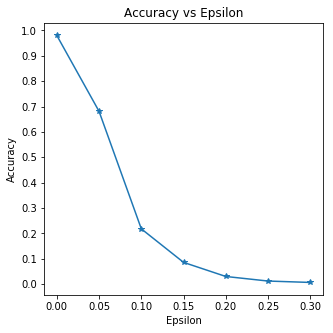

In [6]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

## Visualization of the targets after the attack

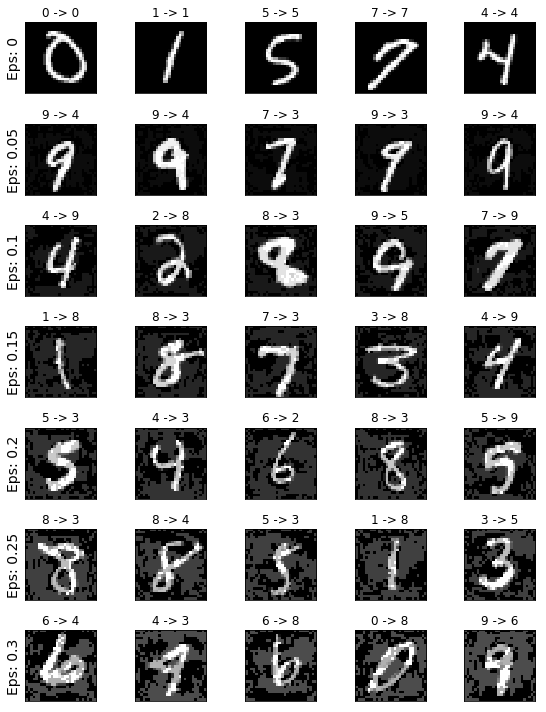

In [7]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()